<a href="https://colab.research.google.com/github/pogoryelov/Customer-complaint-classification/blob/main/Customer_complaint_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer complaint case**

The Consumer Complaint Database is a collection of complaints about consumer financial products and services.

The task is to develop a ML model that takes in the ‘Consumer complaint narrative’ text field and predicts the Product for the complaint. 

# **1. Load libraries & Import data**

## Load libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
from zipfile import ZipFile
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## Import data

In [ ]:
# Load data from pre-downloaded dataset into Pandas DataFrame
# zf = ZipFile('/content/drive/MyDrive/TestCase/If/complaints.csv.zip')

# Load CSV file into dataframe
# df = pd.read_csv(zf.open("complaints.csv"))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# # Download the data from the source and load into Pandas DataFrame
r = requests.get("https://files.consumerfinance.gov/ccdb/complaints.csv.zip")

# # Unzip data archive
files = ZipFile(BytesIO(r.content))

# # Load CSV file into dataframe
df = pd.read_csv(files.open("complaints.csv"))

# **2. Exploratory data analysis and data preparation**

The full dataset contains of over 2.7 million rows and 18 features

In [ ]:
df.shape

(2731880, 18)

In [ ]:
# Percentage of complaints with text
total = df['Consumer complaint narrative'].notnull().sum()
round((total/len(df)*100),1)

35.2

Since our task is to predict which Product is to recommend based on consumer's complaint, we can only select those two fields.

At the same time we also remove all the rows with the missing values. This would reduce the size of the dataset little below 1 million rows (which is about 35% from the full dataset length)

In [ ]:
# Create the case dataframe with two relevant features and remove missing values
df_case = df[['Product', 'Consumer complaint narrative']].dropna()

print(df_case.shape)
df_case.head(10)

(960852, 2)


,Product,Consumer complaint narrative
3,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
7,Mortgage,The mortgage bank has not been crediting my VA...
31,Debt collection,XXXX XXXX never sent information to verify debt
43,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting A...
48,"Credit reporting, credit repair services, or o...",Over the course of 30 days I have filed a disp...
49,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso..."
61,Debt collection,I have not received information to verify this...
63,"Credit reporting, credit repair services, or o...","To Whom It May Concern, Please be advised that..."
68,"Credit reporting, credit repair services, or o...",I AM A NATURAL PERSON & CONSUMER FILING THIS C...
70,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...


Next we can check what are the categories (Products) into which we need to classify consumer complaints:

In [ ]:
# List all unique Products
feature_len = len(pd.DataFrame(df_case.Product.unique()))
print(f'Number of unique products: {feature_len}')
pd.DataFrame(df_case.Product.unique()).values

Number of unique products: 18


array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Debt collection'],
       ['Credit card or prepaid card'],
       ['Vehicle loan or lease'],
       ['Checking or savings account'],
       ['Payday loan, title loan, or personal loan'],
       ['Student loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Consumer Loan'],
       ['Payday loan'],
       ['Credit card'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Other financial service'],
       ['Money transfers'],
       ['Prepaid card'],
       ['Virtual currency']], dtype=object)

There are overall 18 diferent products. However we can see that some of the products are overlapping, e.g., *'Credit card or prepaid card'* includes in itself separate products *'Credit card'* and *'Prepaid card'*.

To avoid future confusion of the classification which might result in degraded model performance we can rename certain categories (Products) and as a result merge them into one.

In [ ]:
# Rename categories
df_case_merge = df_case.replace({'Product': 
             {'Credit reporting': 'Credit reporting, credit repair services, or other personal consumer reports',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfers': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}
             )

In [ ]:
# List all unique Products
feature_len = len(pd.DataFrame(df_case_merge.Product.unique()))
print(f'Number of unique products: {feature_len}')
pd.DataFrame(df_case_merge.Product.unique()).values

Number of unique products: 12


array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Debt collection'],
       ['Credit card or prepaid card'],
       ['Vehicle loan or lease'],
       ['Checking or savings account'],
       ['Payday loan, title loan, or personal loan'],
       ['Student loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Consumer Loan'],
       ['Bank account or service'],
       ['Other financial service']], dtype=object)

We can now dig into how many complaints are in each category. To do that we will plot a bar chart and sort by number of complaints

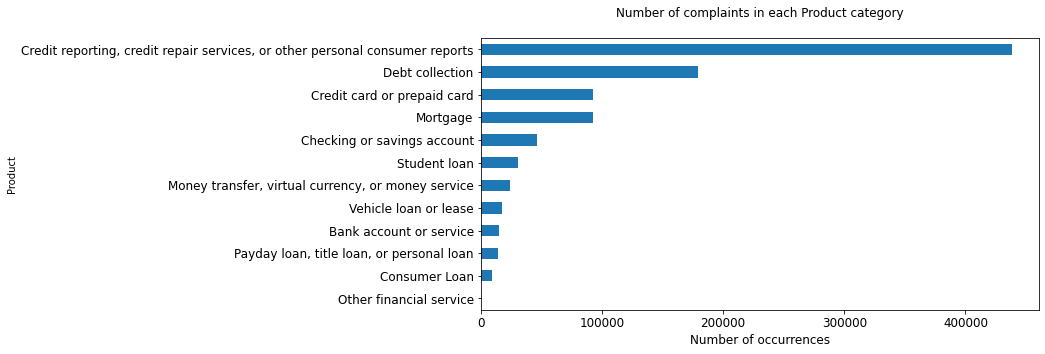

In [ ]:
fig = plt.figure(figsize=(10,5))
df_case_merge.groupby('Product')['Consumer complaint narrative'].count().sort_values().plot.barh(
    ylim=0, title= 'Number of complaints in each Product category\n', fontsize = 12)
plt.xlabel('Number of occurrences', fontsize = 12);

To simplify the modelling at this point let us only select the top 5 product categories by the number of complaints

In [ ]:
# Show top 5 product categories (by count of complaints)
df_case_merge['Product'].value_counts().sort_values(ascending=False).head(5)

Credit reporting, credit repair services, or other personal consumer reports    438480
Debt collection                                                                 178914
Credit card or prepaid card                                                      92710
Mortgage                                                                         92657
Checking or savings account                                                      46220
Name: Product, dtype: int64

In [ ]:
# Select top 5 product categories
keep_values = ['Credit reporting, credit repair services, or other personal consumer reports',
               'Debt collection',
               'Credit card or prepaid card',
               'Mortgage',
               'Checking or savings account'
               ]
df_case_top = df_case_merge.copy()
df_case_top = df_case_top[df_case_top['Product'].str.contains('|'.join(keep_values))]

We can represent each of the selected categories as a number. That would help our predictive model to better handle different categories.

In [ ]:
# Create a new column 'category_id' with encoded categories 
df_case_top['category_id'] = df_case_top['Product'].factorize()[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


At this point it is also useful to make sure that later we can easily recover category names from category ID's. For that we can create dictionaries:

In [ ]:
# Make a list of unique categories and their IDs
df_category_id = df_case_top[['Product', 'category_id']].drop_duplicates()

# Create dictionaries
category_to_id = dict(df_category_id.values)
id_to_category = dict(df_category_id[['category_id', 'Product']].values)

In order to further reduce the computation time at this point we can sample the data

In [ ]:
# Create a sampled dataframe
df_case_sample = df_case_top.sample(10000, random_state=42).copy()

In [ ]:
df_case_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1833700 to 1514610
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       10000 non-null  object
 1   Consumer complaint narrative  10000 non-null  object
 2   category_id                   10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


# **3. Text Preprocessing**

Whenever we apply any algorithm to textual data, we need to convert the text to a numeric form. Hence, there arises a need for some pre-processing techniques that can convert our text to numbers. Both bag-of-words (BOW) and TFIDF are pre-processing techniques that can generate a numeric form from an input text.

* **Bag-of-Words**

The bag-of-words model converts text into fixed-length vectors by counting how many times each word appears.

However Bag-of-words does not bring in any information on the meaning of the text. Sometimes simply the word order in the sentence changes its meaning, but bag-of-words model would create the same vectors in each case.

* **Term Frequency Inverse Document Frequency (TFIDF)**

TFIDF works by proportionally increasing the number of times a word appears in the document but is counterbalanced by the number of documents in which it is present. Hence, words like ‘this’, ’are’ etc., that are commonly present in all the documents are not given a very high rank. However, a word that is present too many times in a few of the documents will be given a higher rank as it might be indicative of the context of the document.

The limitation of TFIDF is again that this vectorization doesn’t help in bringing in the contextual meaning of the words as it is just based on the frequency.

For our case study TFIDF algorythm will be more suitable.


In [ ]:
# We transform each complaint into a vector
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=.95, ngram_range=(1, 2), stop_words='english')

X_vect = vectorizer.fit_transform(df_case_sample['Consumer complaint narrative']).toarray()
y = df_case_sample.category_id

# **4. Model selection**

Since our task is to classify the textual data we need to select the model suitable for that task.

However as we are not sure which model would perform best in our particular case we can first select several models applicable for text classification and after initial evaluation choose the one that performs best.

Here are the models that will be evaluated:

* **Multinomial Naive Bayes**
> Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP). The algorithm is based on the Bayes theorem and predicts the tag of a text such as a piece of email or newspaper article. It calculates the probability of each tag for a given sample and then gives the tag with the highest probability as output. Naive Bayes classifier is a collection of many algorithms where all the algorithms share one common principle, and that is each feature being classified is not related to any other feature. The presence or absence of a feature does not affect the presence or absence of the other feature.

* **Linear Support Vector Machine**
> For the text classification process, the SVM algorithm categorizes the classes of a given dataset by determining the best hyperplane or boundary line that divides the given text data into predefined groups. The SVM algorithm creates multiple hyperplanes, but the objective is to find the best hyperplane that accurately divides both classes. The best hyperplane is selected by selecting the hyperplane with the maximum distance from data points of both classes. The vectors or data points nearer to the hyperplane are called support vectors, which highly influence the position and distance of the optimal hyperplane.

* **Logistic Regression**
> Logistic regression is widely used in machine learning for all sorts of classification problems and is especially popular for text classification. The logistic regression classifier uses the weighted combination of the input features and passes them through a sigmoid function. Sigmoid function transforms any real number input, to a number between 0 and 1.

In [ ]:
models = [
    MultinomialNB(),
    LinearSVC(random_state=42),
    LogisticRegression(random_state=42, max_iter = 200)
    ]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_vect, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8600,0.008631
LogisticRegression,0.8518,0.004251
MultinomialNB,0.7273,0.007379


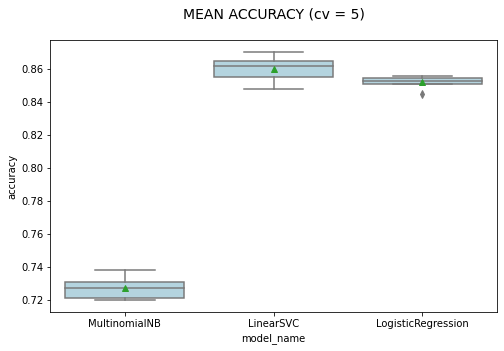

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

# **5. Train/Test data splitting**

Split the data into 75% training and 25% testing, with stratified sampling, to make sure that the classes percentages in both training and testing data are (nearly) equal.

In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_vect, y, df_case_sample.index, test_size=0.25, random_state=42, stratify = y)

# **6. Model evaluation**

To evaluate the model performance we will assess:
* **Accuracy**: the percentage of texts that were categorized with the correct tag.
* **Precision**: the percentage of examples the classifier got right out of the total number of examples that it predicted for a given tag.
* **Recall**: the percentage of examples the classifier predicted for a given tag out of the total number of examples it should have predicted for that given tag.
* **F1 Score**: the harmonic mean of precision and recall.

## Multinomial Naive Bayes

In [ ]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred_nb, target_names= df_case_sample['Product'].unique()))

				CLASSIFICATIION METRICS

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.67      0.97      0.79      1292
                                                             Debt collection       0.94      0.65      0.77       272
                                                 Credit card or prepaid card       0.82      0.50      0.62       535
                                                                    Mortgage       0.68      0.29      0.40       264
                                                 Checking or savings account       1.00      0.05      0.10       137

                                                                    accuracy                           0.71      2500
                                                                   macro avg       0.82      0.49      0.54      2500
                         

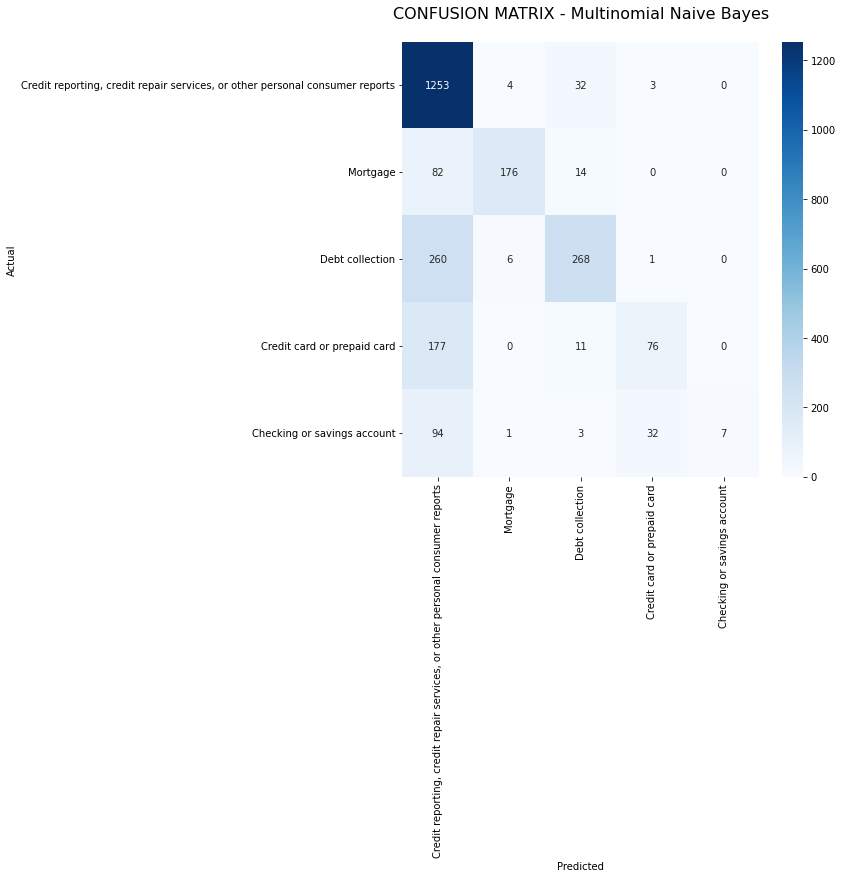

In [ ]:
# Build Confusion matrix
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat_nb, annot=True, cmap="Blues", fmt='d',
            xticklabels=df_category_id.Product.values, 
            yticklabels=df_category_id.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Multinomial Naive Bayes\n", size=16);

## Linear Support Vector Machine

In [ ]:
model_svc = LinearSVC(random_state=42)
model_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred_svc, target_names= df_case_sample['Product'].unique()))

				CLASSIFICATIION METRICS

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.88      0.90      0.89      1292
                                                             Debt collection       0.91      0.90      0.90       272
                                                 Credit card or prepaid card       0.79      0.76      0.77       535
                                                                    Mortgage       0.79      0.75      0.77       264
                                                 Checking or savings account       0.84      0.85      0.84       137

                                                                    accuracy                           0.85      2500
                                                                   macro avg       0.84      0.83      0.84      2500
                         

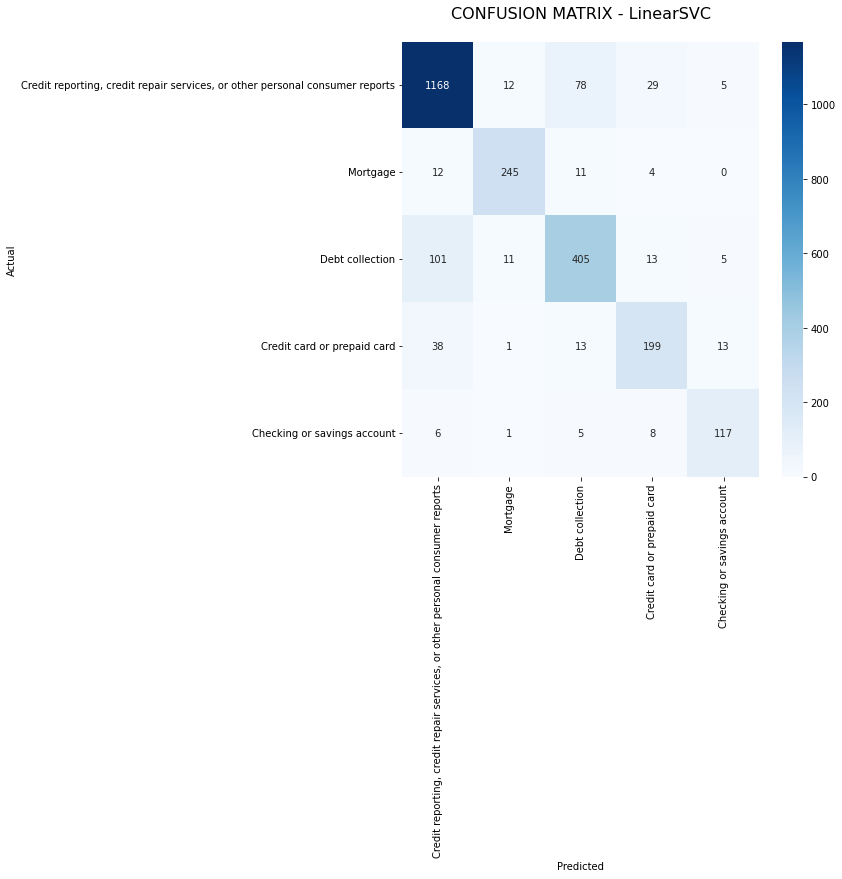

In [ ]:
# Build Confusion matrix
conf_mat_svc = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat_svc, annot=True, cmap="Blues", fmt='d',
            xticklabels=df_category_id.Product.values, 
            yticklabels=df_category_id.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

## Logistic Regression

In [ ]:
model_lr = LogisticRegression(random_state=42, max_iter = 200)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred_lr, target_names= df_case_sample['Product'].unique()))

				CLASSIFICATIION METRICS

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.85      0.93      0.89      1292
                                                             Debt collection       0.92      0.85      0.89       272
                                                 Credit card or prepaid card       0.80      0.73      0.76       535
                                                                    Mortgage       0.79      0.70      0.75       264
                                                 Checking or savings account       0.94      0.76      0.84       137

                                                                    accuracy                           0.84      2500
                                                                   macro avg       0.86      0.79      0.82      2500
                         

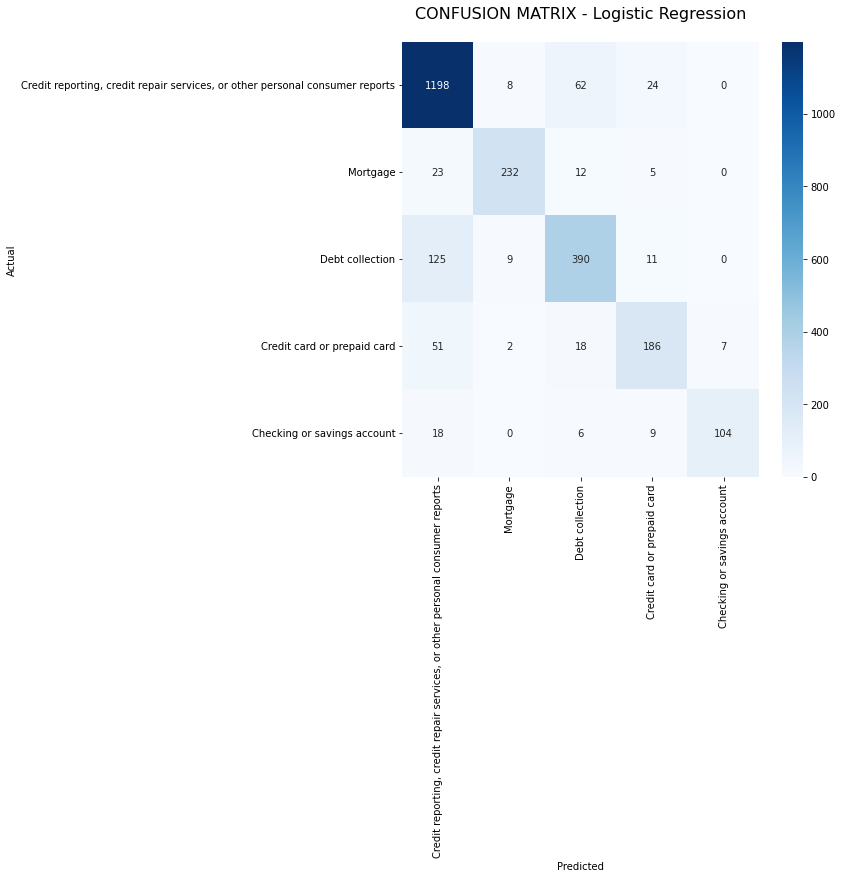

In [ ]:
# Build Confusion matrix
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat_lr, annot=True, cmap="Blues", fmt='d',
            xticklabels=df_category_id.Product.values, 
            yticklabels=df_category_id.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size=16);

# **7. Further steps and improvements**

There are obviously lots of other things that can be done to improve the performance and accuracy of ML model(s).
* Expand classification to all categories (Products).
* Increase the number of samples and run the code in different environment (Google Colab seems to run out of memory when using over 10000 samples).
* Make sure that the model is not over-fitting on the training data, and it generalizes well on the whole data, the more the model generalizes the better it performs.
> This can be achieved with k-fold Cross Validation (similar to what was used when comparing models' accuracy in the "**Model Selection**" section above). That way we make sure that the whole data is exposed to the model, so we don’t just fit the model on the training data, instead, we split the training data into k-folds and for each fold we do the following:
> * Train the model using the k-1 folds.
> * Use the remaining fold as a validation set.
>
> After performing the previous two steps for each fold we finally evaluate the model using the held out test set.

* Find a set of optimal hyper-parameters for our model that yields the best results.
> This can be achieved by performing a Grid Search.
Sklearn supports both cross validation (from the point above) and hyper-parameters tuning in one place: ***GridSearchCV***

* Dimensionality Reduction
> Even though we removed stop words and are applying thresholds to the tf-idf vectorizer, it still leaves us with a lot of unique words, many of which we probably don’t need and are redundant.
>
> Perform Latent Semantic Analysis (LSA) which is a dimensionality reduction technique. LSA uses Singular Value Decomposition (SVD) to reduce the number of dimensions and select the best ones.

* Explore the misclassified complaints and try to figure out ways to improve the outcome.

* Evaluate possibility of using Deep Learning for text classification
> Deep learning architectures offer huge benefits for text classification because they perform at super high accuracy with lower-level engineering and computation.
>
>The two main deep learning architectures for text classification are Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN). Possible problem with particular dataset is that Deep learning algorithms do require much more training data than traditional machine learning algorithms (at least millions of tagged examples).